In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

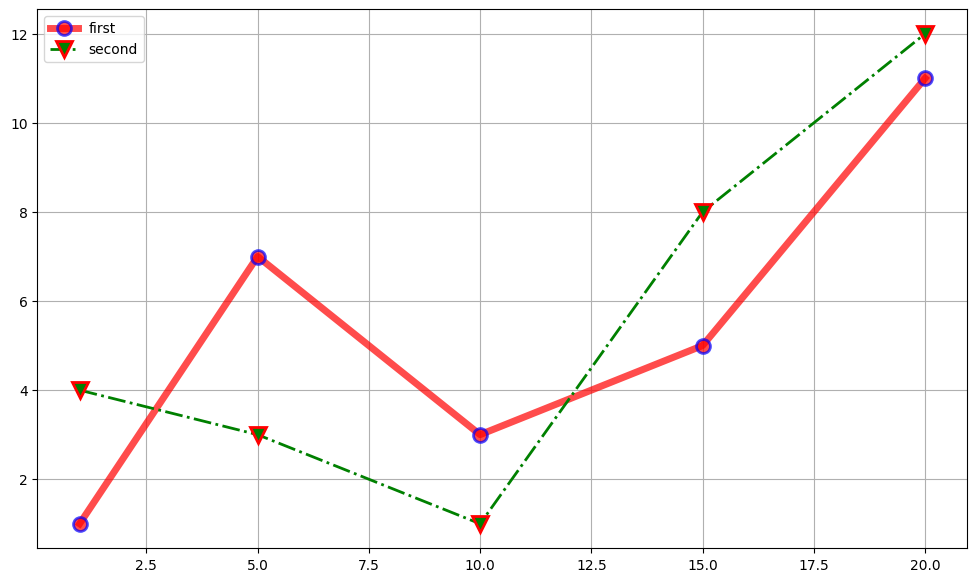

In [2]:
x = [1, 5, 10, 15, 20]
y1 = [1, 7, 3, 5, 11]
y2 = [4, 3, 1, 8, 12]
plt.figure(figsize=(12, 7))
plt.plot(x, y1, 'o-r', alpha=0.7, label="first", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-.g', label="second", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical
from torchmetrics.text import WordErrorRate
from torchvision.io import read_image
from torchvision.models import MobileNet_V2_Weights, mobilenet_v2
from torchvision.models import EfficientNet_V2_M_Weights, efficientnet_v2_m, EfficientNet_V2_S_Weights, efficientnet_v2_s
import numpy as np
import shutil
from collections import defaultdict
from functools import partial
from itertools import chain
import os
import json
import typing
from typing import Optional
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sacrebleu import corpus_bleu
from collections import defaultdict
from accelerate import Accelerator
from PIL import Image
import re

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers.processors import TemplateProcessing

os.environ["TOKENIZERS_PARALLELISM"] = "true"

C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
# фиксации параметров в рамках всего запуска
def seed_everything(seed: int) -> None:
    import os
    import random
    import torch
    import numpy as np

    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def seed_worker(worker_id):
    import random
    import numpy as np
    import torch
    
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

SEED = 13
seed_everything(SEED)

import torch
g = torch.Generator()
g.manual_seed(0)

# accelerator = Accelerator(mixed_precision="no", cpu=True)
accelerator = Accelerator(mixed_precision="no")

device = accelerator.device
print(device)

cuda


In [5]:
def get_target(data_dir: Path,
               le: typing.Optional[LabelEncoder] = None,
               label_encoder_pickle_file: Path = Path.cwd() / "data" / "labelencoder.pkl",
               feedbacks : bool = True,
               level : int = 1,
               category1: str = None,
               category2: str = None,
               category3: str = None,
               category4: str = None,
               ):

    folders = os.listdir(data_dir)
    
    if level not in range(1,6):
        raise ValueError("The value of 'level' must be 1, 2, 3, 4 or 5")
    
    if level == 1:
        categories = folders

    elif level == 2:
        if category1 is None:
            raise TypeError("choose_category() missing 1 required positional argument: 'category1'")
        categories = [category for category in folders if category.split("_")[0]==category1]

    elif level == 3:
        if category1 is None or category2 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1' or 'category2'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2)]

    elif level == 4:
        if category1 is None or category2 is None or category3 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2' or 'category3'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3)]

    elif level == 5:
        if category1 is None or category2 is None or category3 is None  or category4 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2', 'category3' or 'category4'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3) and (category.split("_")[3]==category4)]
    
    if feedbacks:
        paths_card = [data_dir / category / "card" for category in categories]
        paths_feedbacks = [data_dir / category / "feedbacks" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card + paths_feedbacks]
        img_paths = list(chain(*img_paths))
    else:
        paths_card = [data_dir / category / "card" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card]
        img_paths = list(chain(*img_paths))
    
    target = [path.parts[-3:-2][0] for path in img_paths]
    
    if not le:
        le = LabelEncoder()
        le = le.fit(target)

    target_enc = le.transform(target)

    # Соотнесения закодированного таргета и названий категорий
    dict_topic = dict(zip(target, target_enc))
    target2idx = dict(sorted(dict_topic.items(), key=lambda item: item[1]))
    idx2target = dict(zip(target_enc, target))

    return img_paths, torch.from_numpy(target_enc).long(), target2idx, idx2target


def get_traintestsplit(img_paths : list[Path],
                       target_enc : list,
                       SEED : int,
                       ):
    
    train_paths, test_paths, ytrain, ytest = train_test_split(img_paths, target_enc,
                                                              test_size=0.2,
                                                              stratify=target_enc,
                                                              random_state=SEED)
    return train_paths, test_paths, ytrain, ytest

In [6]:
from tokenizers.models import WordLevel, WordPiece
from tokenizers.trainers import WordLevelTrainer, WordPieceTrainer

In [27]:
def delete_none_items(paths: list[Path],
                      descriptions: pd.DataFrame,
                      embeddings: torch.Tensor):
    
    descriptions.reset_index(inplace=True)
    ind_isna = descriptions[descriptions["description"].isna()].index.tolist()
    ind_notna = descriptions[descriptions["description"].notna()].index.tolist()
    
    # удаление
    descriptions.drop(index=ind_isna, inplace=True)
    paths = list(pd.DataFrame(paths, columns=["paths"]).drop(index=ind_isna)["paths"])
    embeddings = torch.index_select(embeddings, dim=0, index=torch.from_numpy(np.array(ind_notna)))
    
    return paths, descriptions, embeddings


def text_prepocessing(text: str) -> str:
    text = text.lower()
    #text = re.sub(r"[^0-9a-zA-Zа-яА-ЯёЁ]", " ", text)
    text = re.sub(r"\s+", " ", text)    
    return text


def get_descriptions_and_embeds(paths: list[Path]):
    descriptions = []
    embeddings_check = False
    
    for path in paths:
        line = pd.read_csv(path.parents[1] / "descriptions.csv", index_col="item").loc[path.name]
        descriptions.append(line)
        
        embed = pd.read_csv(path.parents[1] / "embeddings.csv", index_col="item").loc[path.name]["embedding"].encode().decode('unicode-escape').encode('ISO-8859-1')[2:-1]
        embed = torch.from_numpy(np.copy(np.frombuffer(embed, dtype=np.float32))).view(1, -1)
        if embeddings_check:
            embeddings = torch.cat([embeddings, embed], dim=0)
        else:
            embeddings = torch.cat([embed], dim=0)
            embeddings_check = True
        
        
    df = pd.DataFrame(descriptions)
    paths, df, embeddings = delete_none_items(paths, df, embeddings)
    df['descriptions_preproc'] = df.description.apply(text_prepocessing)
    return df, embeddings, paths


def get_tokenizer(df_descriptions, saving : bool = False):
    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]", "[UNK]"])

    # обучение
    tokenizer.train_from_iterator(df_descriptions["descriptions_preproc"], trainer=trainer)
    
    # создаем шаблон, как надо выдавать предложения
    tokenizer.post_processor = TemplateProcessing(
        single="[BOS] $A [EOS]",
        special_tokens=[
            ("[BOS]", tokenizer.token_to_id("[BOS]")),
            ("[EOS]", tokenizer.token_to_id("[EOS]")),
        ],
    )
    
    if saving:
        # сохранили в файл
        tokenizer.save("tokenizer.json") 
    
    return tokenizer

In [28]:
#tokenizer.token_to_id("[PAD]")
#tokenizer.encode("маша мыла раму. петя пишет AAA там тут и сям. +").ids

In [29]:
data_dir = Path("C:/temp/!hse-mlds-project-year2") / "test"
processor = MobileNet_V2_Weights.IMAGENET1K_V2.transforms(
    antialias=True,
)

# в данной функции определяется надо ли исп-ть feedbacks и какие категории брать
img_paths, target_enc, _, idx2target = get_target(data_dir,
                                                  feedbacks=False,
                                                  level=2,
                                                  category1="Канцтовары",
                                                  category2="Бумажная&продукция")
train_paths, test_paths, ytrain, ytest = get_traintestsplit(img_paths, target_enc, SEED)
print(len(train_paths), len(test_paths))

368 92


In [30]:
descriptions_train, embeddings_train, train_paths = get_descriptions_and_embeds(train_paths)
descriptions_test, embeddings_test, test_paths = get_descriptions_and_embeds(test_paths)

tokenizer = get_tokenizer(descriptions_train)
print(tokenizer.get_vocab_size())                       # посмотрим на размер словаря

print(len(train_paths), len(test_paths))
descriptions_train

16072
367 92


,index,description,descriptions_preproc
0,19.png,Сертификат профилактических прививок предъявля...,сертификат профилактических прививок предъявля...
1,16.png,Манекен человека художественный используется п...,манекен человека художественный используется п...
2,16.png,Диплом выпускнику начальной школы станет отлич...,диплом выпускнику начальной школы станет отлич...
4,1.png,В упаковке 10 тетрадей в частую косую линейку ...,в упаковке 10 тетрадей в частую косую линейку ...
5,11.png,"Свадьба - романтичное и радостное событие, кот...","свадьба - романтичное и радостное событие, кот..."
...,...,...,...
363,9.png,Закладки BRAUBERG - одни из самых удобных закл...,закладки brauberg - одни из самых удобных закл...
364,12.png,"Кассовая лента 57 мм, намотка 15 метров, идеал...","кассовая лента 57 мм, намотка 15 метров, идеал..."
365,8.png,- Sar 30 E - универсальный однокомпонентный по...,- sar 30 e - универсальный однокомпонентный по...
366,15.png,Читательский дневник поможет ребёнку вниматель...,читательский дневник поможет ребёнку вниматель...


In [32]:
#tokenizer.get_vocab()

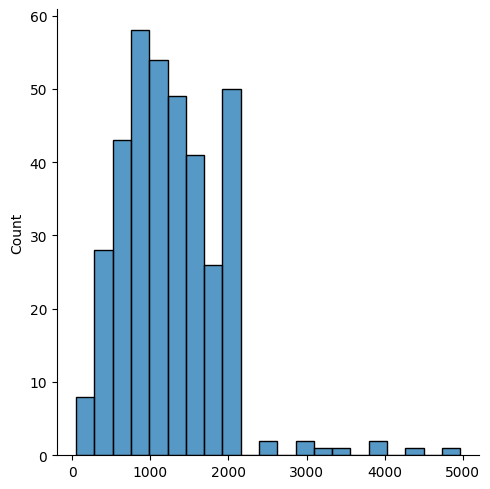

In [25]:
#Посмотрим на длину последоватеьностей
_ = sns.displot([len(sent) for sent in descriptions_train["descriptions_preproc"]])

In [12]:
class WbDataset(Dataset):
    def __init__(self,
                 img_paths: list[Path],
                 img_embeds: torch.Tensor,
                 descriptions: list[str],
                 tokenizer: Tokenizer,
                 max_length: int = 5000,
                ):

        self.img_paths = img_paths
        self.img_embeds = img_embeds
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.descriptions = descriptions
        
    def __getitem__(self, index):
        img_path = self.img_paths[index]

        ids = self.tokenizer.encode(self.descriptions[index]).ids[:self.max_length]
        out = {"embed": self.img_embeds[index], "description": ids, "path": str(img_path)}
 
        return out


    def __len__(self):
        return len(self.img_embeds)

In [13]:
train_dataset = WbDataset(img_paths=train_paths,
                          img_embeds=embeddings_train,
                          descriptions=descriptions_train["descriptions_preproc"],
                          tokenizer=tokenizer,
                         )

test_dataset = WbDataset(img_paths=test_paths,
                         img_embeds=embeddings_test,
                         descriptions=descriptions_test["descriptions_preproc"],
                         tokenizer=tokenizer,
                         )

In [14]:
item = train_dataset[0]

print(item.keys())
print(item["embed"].shape)
print(len(item["description"]))
print(len(tokenizer.decode(item["description"]).split()))

dict_keys(['embed', 'description', 'path'])
torch.Size([1024])
161
159


In [16]:
class Collator:
    def __init__(self, transform=None, mixes=None) -> None:
        self.transform = transform
        self.mixes = mixes

    def __call__(self, batch):
        tensor_dict = defaultdict(list)
        for sample in batch:
            for key, value in sample.items():
                tensor_dict[key].append(value)

        data = torch.stack(tensor_dict["embed"])
        
        # Pad values
        out = {
            "embed": data,
            "description": pad_sequence([torch.tensor(t) for t in tensor_dict["description"]], batch_first=True),
            "path": tensor_dict["path"],
        }

        return out

In [17]:
# train_dataset = torch.utils.data.Subset(train_dataset, [i for i in range(8)])
# test_dataset = torch.utils.data.Subset(test_dataset, [i for i in range(8)])
BATCH_SIZE = 32

train_loader = accelerator.prepare_data_loader(DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               collate_fn=Collator(),
                                               pin_memory=True,
                                               generator=torch.Generator().manual_seed(SEED),
                                               worker_init_fn=seed_worker)
                                                                  )


val_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

In [18]:
elem = next(iter(train_loader))
#elem['img'][0].shape

# visualise_1pic(elem[0][0])

In [19]:
elem["embed"].shape

torch.Size([32, 1024])

In [20]:
elem['description'].shape

torch.Size([32, 274])

In [21]:
elem['description'][0]

tensor([   1, 7036,  825,  636, 8940,    5,  232, 1296,    4, 1250,  241,   28,
         636, 1601,    6, 1132, 2110, 4212, 9368, 4415,    6,  217,  501, 1358,
         428,    4, 9327,   96, 1763,    8,  796,  499, 1875, 1358, 7897,    7,
        8605, 7507, 2213, 1562, 1732, 1741, 9213,    4, 9294, 6631, 8076,  624,
        6222, 5269,    4, 5762,  911,    8,  145, 1358,   16, 7614,   39, 1407,
        8811,  109, 8289,    8, 6221, 9905,   86,  398, 3096, 2681,    2,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

___

Нерешенные вопросы:
 - подумать какой лучше брать токенайзер
 - как делать предикт:
   - categorical или argmax
   - критерии останова
   - как прогонять сразу батчом

In [23]:
class DecoderRNN(nn.Module):
    def __init__(
        self,
        tokenizer: Tokenizer,
        image_embed_dim,
        embed_dim : int = 256,
        hidden_dim : int = 256,
        lstm_layers : int = 1,
        dropout_prob: float = 0.1,
    ):
        super().__init__()
        
        self.lstm_layers = lstm_layers
        self.hidden_dim = hidden_dim
        self.tokenizer = tokenizer
        
        self.image_embed_to_h0 = torch.nn.Sequential(
            torch.nn.Linear(in_features=image_embed_dim, out_features=lstm_layers * hidden_dim),
            torch.nn.LeakyReLU(0.1),
        )
        self.image_embed_to_c0 = torch.nn.Sequential(
            torch.nn.Linear(in_features=image_embed_dim, out_features=lstm_layers * hidden_dim),
            torch.nn.LeakyReLU(0.1),
        )
        
        self.embed = torch.nn.Embedding(
            num_embeddings=tokenizer.get_vocab_size(),
            embedding_dim=embed_dim,
            padding_idx=tokenizer.get_vocab()["[PAD]"],
        )
        self.lstm = torch.nn.LSTM(
            input_size=embed_dim, 
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True, 
        )
        self.linear = torch.nn.Sequential(
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(in_features=hidden_dim, out_features=tokenizer.get_vocab_size()),
        )

    def forward(self, image_embeds, captions):
        batch_size = image_embeds.shape[0]
        h0 = self.image_embed_to_h0(image_embeds).reshape(batch_size, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        c0 = self.image_embed_to_c0(image_embeds).reshape(batch_size, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        
        embeds = self.embed(captions)
        lengths = (captions != 0).sum(dim=-1).cpu()
        
        packed = pack_padded_sequence(embeds, lengths=lengths, batch_first=True, enforce_sorted=False)
        lstm_out, (h, c) = self.lstm(packed, (h0, c0))
        output, lens_unpacked = pad_packed_sequence(lstm_out, batch_first=True)
#         print(output.shape)
        logits = self.linear(output)
#         print(logits.shape)

        return logits
    
    
    @torch.no_grad()
    def caption_image(
        self,
        image_embeds : torch.Tensor,
        max_length : int = 300,
    ):
        self.eval()

        batch_size = image_embeds.shape[0]
        
        if batch_size > 1:
            raise ValueError(f'Expected input batch_size (1) but got ({batch_size})')
        h = self.image_embed_to_h0(image_embeds).reshape(batch_size,
                                                                    self.lstm_layers,
                                                                    self.hidden_dim).transpose(0, 1)
        c = self.image_embed_to_c0(image_embeds).reshape(batch_size,
                                                                    self.lstm_layers,
                                                                    self.hidden_dim).transpose(0, 1)

        # init tokens with <bos>
        tokens = torch.full((batch_size, 1), self.tokenizer.get_vocab()["[BOS]"], device=image_embeds.device)
        new_tokens = tokens
        
        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < max_length:
            if ((tokens == self.tokenizer.get_vocab()["[EOS]"]).sum(1) > 0).all():   # тут надо проверить
                break  

            embeds = self.embed(new_tokens)
            output, (h, c) = self.lstm(embeds, (h, c))
#             print(output.shape)
            logits = self.linear(output)

            new_tokens = Categorical(logits=logits).sample()      #logits.argmax(dim=-1)
            tokens = torch.cat([tokens, new_tokens], dim=1)                              # концовка будет другая

        return tokens

In [24]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_metrics, valid_metrics):
    clear_output()
    fig, axs = plt.subplots(2, 2, figsize=(26, 13))
    axs[0][0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0][0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0][0].set_ylabel('loss')

    for (ax1, ax2), train_m_name, valid_m_name in zip(((0, 1), (1, 0), (1, 1)), train_metrics, valid_metrics):
        train_m, valid_m = train_metrics[train_m_name], valid_metrics[valid_m_name]
        axs[ax1][ax2].plot(range(1, len(train_m) + 1), train_m, label='train')
        axs[ax1][ax2].plot(range(1, len(valid_m) + 1), valid_m, label='test')
        axs[ax1][ax2].set_ylabel(train_m_name)

    for ax1 in axs:
        for ax2 in ax1:
            ax2.set_xlabel('epoch')
            ax2.legend()

    plt.show()

    
def calculate_bleu_wer(model, image_embeds, captions_true):
    bleu_scores = []
    wer_scores = []
    wer = WordErrorRate()
    
    for i in range(image_embeds.shape[0]):
        caption_pred = model.caption_image(image_embeds=image_embeds[i].view(1, -1))

        caption_true = model.tokenizer.decode(captions_true[i].detach().cpu().numpy())
        caption_pred = model.tokenizer.decode(caption_pred[0].detach().cpu().numpy())
    
        bleu_score = corpus_bleu(caption_pred, [caption_true]).score
        bleu_scores.append(bleu_score)
        
        wer_score = wer(caption_pred, caption_true)
        wer_scores.append(wer_score)
    
    bleu = np.mean(bleu_scores)
    wer = np.mean(wer_scores)
    
    return {"BLEU": bleu, "WER": wer}

In [25]:
class Trainer:
    def __init__(
        self,
        model,
        optimizer,
        scheduler,
        criterion,
        accelerator,
        device,
    ):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.accelerator = accelerator
        self.device = device

    @staticmethod
    def training_epoch(
        self,
        train_loader: DataLoader,
        epoch: int,
        tqdm_desc,
        train_metrics,
        metric_epoch : int,
        metrics_freq: int,
    ):
        num_batches = 0.0
        train_loss = 0.0
        metrics = defaultdict(float)
        self.model.train()
        
        for batch in tqdm(train_loader, desc=tqdm_desc):
            img_embed = batch["embed"]
            descriptions = batch["description"]
            
            with self.accelerator.accumulate(self.model):
                logits_captioning = self.model(img_embed, descriptions[:, :-1])
                loss = self.criterion(logits_captioning.transpose(1, 2), descriptions[:, 1:])
                self.accelerator.backward(loss)
                self.optimizer.step()
                self.optimizer.zero_grad()

            train_loss += loss.item()
            
            if (metric_epoch) % metrics_freq == 0:
                metrics_captioning = calculate_bleu_wer(model, batch['embed'], batch['description'])
                for m_name, m in metrics_captioning.items():
                    metrics[m_name] += m
    
            num_batches += 1

        train_loss /= num_batches
        if (metric_epoch) % metrics_freq == 0:
            for m_name in metrics:
                metrics[m_name] /= num_batches
        else:
            for m_name in train_metrics:
                metrics[m_name] = train_metrics[m_name][-1]
            
        return train_loss, metrics

    @staticmethod
    @torch.no_grad()
    def validation_epoch(
        self,
        val_loader: DataLoader,
        epoch: int,
        tqdm_desc,
        val_metrics,
        metric_epoch : int,
        metrics_freq: int,
    ):
        num_batches = 0.0
        val_loss = 0.0
        metrics = defaultdict(float)
        self.model.eval()
        for batch in tqdm(val_loader, desc=tqdm_desc):
            img_embed = batch["embed"]
            descriptions = batch["description"]
            
            logits_captioning = self.model(img_embed, descriptions[:, :-1])
            loss = self.criterion(logits_captioning.transpose(1, 2), descriptions[:, 1:])

            val_loss += loss.item()
            
            if (metric_epoch) % metrics_freq == 0:
                metrics_captioning = calculate_bleu_wer(model, batch['embed'], batch['description'])
                for m_name, m in metrics_captioning.items():
                    metrics[m_name] += m

            num_batches += 1

        val_loss /= num_batches
        if (metric_epoch) % metrics_freq == 0:
            for m_name in metrics:
                metrics[m_name] /= num_batches
        else:
            for m_name in val_metrics:
                metrics[m_name] = val_metrics[m_name][-1]

            
        return val_loss, metrics

    def train(
        self,
        train_loader: DataLoader,
        val_loader: DataLoader,
        num_epochs: int,
        plot: bool,
        calculate_metrics: bool = True,
        metrics_freq: int = 10,
        saving_checkpoint: bool = False,
        save_path_checkpoint: Optional[Path] = None,
        saving_model: bool = False,
        save_path_model: Optional[Path] = None,
    ):
        train_losses = []
        val_losses = []
        train_metrics, val_metrics = defaultdict(list), defaultdict(list)

        for epoch in range(1, num_epochs + 1):
            train_loss, train_metric = self.training_epoch(
                self,
                train_loader,
                epoch,
                tqdm_desc=f'Training {epoch}/{num_epochs}',
                train_metrics=train_metrics,
                metric_epoch=epoch-1 if calculate_metrics else epoch, 
                metrics_freq=metrics_freq,
            )
            val_loss, val_metric = self.validation_epoch(
                self,
                val_loader,
                epoch,
                tqdm_desc=f'Validating {epoch}/{num_epochs}',
                val_metrics=val_metrics,
                metric_epoch=epoch-1 if calculate_metrics else epoch,
                metrics_freq=metrics_freq,
            )

            if self.scheduler is not None:
                self.scheduler.step()

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            for m_name, m_value in train_metric.items():
                train_metrics[m_name].append(m_value)
            for m_name, m_value in val_metric.items():
                val_metrics[m_name].append(m_value)
            
            if plot:
                plot_losses(train_losses, val_losses, train_metrics, val_metrics)

            print(f"Epoch {epoch}")
            print("val metrics")
            print(f"loss {val_losses[-1]}")
            for elem in val_metrics.items():
                print(elem[0], elem[1][-1])
            print("\ntrain metrics")
            print(f"loss {train_losses[-1]}")
            for elem in train_metrics.items():
                print(elem[0], elem[1][-1])
            print('-'*50)

            if saving_checkpoint:
                accelerator.save_state(output_dir=save_path_checkpoint / f"checkpoint_afterepoch_{epoch}of{num_epochs}")

        if saving_model:
            shutil.rmtree(save_path_model, ignore_errors=True)
            accelerator.save_state(output_dir=save_path_model)

        return train_losses, val_losses, train_metrics, val_metrics

In [26]:
model = DecoderRNN(
    tokenizer=tokenizer,
    image_embed_dim=embeddings_train.shape[1],
    lstm_layers=3
)

sum(param.numel() for param in model.parameters())

6662328

In [29]:
NUM_EPOCHS = 500

# model = model.to(device)
optimizer = torch.optim.AdamW(
    [
        {"params": model.parameters(), "lr": 3e-4, "weight_decay": 1e-5},
    ],
)
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.get_vocab()["[PAD]"]).to(device)
model, optimizer = accelerator.prepare(model, optimizer)

In [30]:
#NUM_EPOCHS = 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


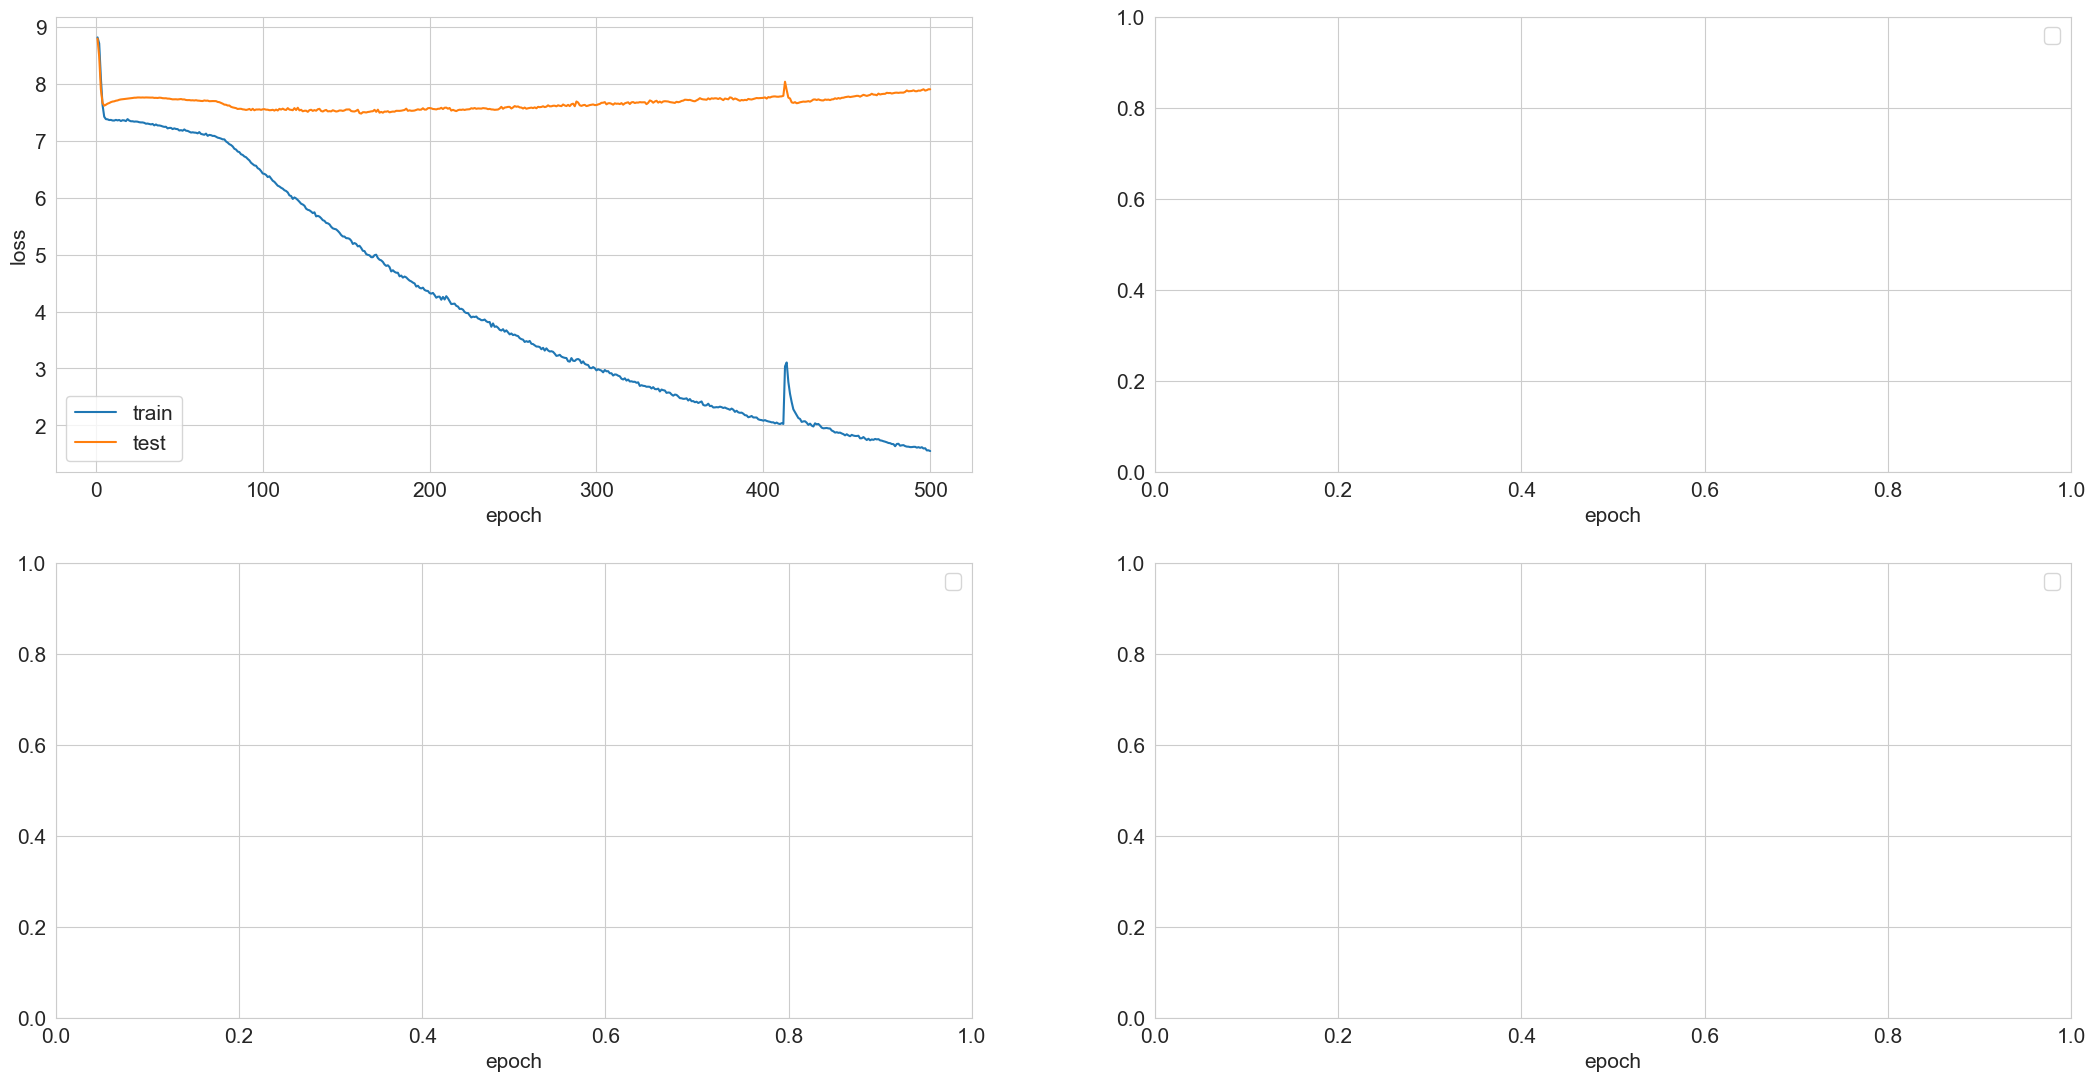

Epoch 500
val metrics
loss 7.907747507095337

train metrics
loss 1.5483036935329437
--------------------------------------------------
0:29:32.046039


In [31]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, plot=True, calculate_metrics=False, metrics_freq=1000)
b = datetime.now()
print(b - a)

In [79]:
one = torch.ones(2, 3, 2)
zero = torch.zeros(2, 3, 2)
three = torch.reshape(torch.arange(1,13), (2, 3, 2))

a1 = torch.cat([one,zero], dim=-1)
torch.cat([a1, three], dim=-1)

tensor([[[ 1.,  1.,  0.,  0.,  1.,  2.],
         [ 1.,  1.,  0.,  0.,  3.,  4.],
         [ 1.,  1.,  0.,  0.,  5.,  6.]],

        [[ 1.,  1.,  0.,  0.,  7.,  8.],
         [ 1.,  1.,  0.,  0.,  9., 10.],
         [ 1.,  1.,  0.,  0., 11., 12.]]])

In [76]:
torch.reshape(torch.arange(1,13), (2, 3, 2))

tensor([[[ 1,  2],
         [ 3,  4],
         [ 5,  6]],

        [[ 7,  8],
         [ 9, 10],
         [11, 12]]])

# Prediction  

In [43]:
test_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
                                             batch_size=1,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

In [36]:
a = datetime.now()
for batch in tqdm(test_loader):
    #break
    metrics = calculate_bleu_wer(model.cpu(), batch['embed'].cpu(), batch['description'].cpu())
    print(metrics)
b = datetime.now()
print(b - a)
print()

  0%|          | 0/240 [00:00<?, ?it/s]

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.6526946}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

{'BLEU': 0.0, 'WER': 0.9010989}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.8939394}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.825}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9306569}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

{'BLEU': 0.0, 'WER': 0.9459459}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.89506173}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.S

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9447236}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.5393258}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.95731705}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])

{'BLEU': 0.0, 'WER': 0.9259259}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

{'BLEU': 0.0, 'WER': 0.9326923}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.92899406}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.S

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.8901099}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9319728}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.2075472}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9320755}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

{'BLEU': 0.0, 'WER': 1.5588236}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.8974359}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.4831461}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9086022}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9222222}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.0333333}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.7058823}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9315069}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.93133044}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.S

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 3.8939395}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.96511626}
torch.S

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9027027}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

KeyboardInterrupt: 

In [34]:
a = datetime.now()
for batch in tqdm(test_loader):
    #break
    metrics = calculate_bleu_wer(model.cpu(), batch['embed'].cpu(), batch['description'].cpu())
    print(metrics)
b = datetime.now()
print(b - a)
print()

# a = datetime.now()
# for batch in tqdm(test_loader):
#     metrics = calculate_bleu_wer(model.to(device), batch['embed'].to(device), batch['description'].to(device))
#     print(metrics)
# b = datetime.now()
# print(b - a)

  0%|          | 0/60 [00:00<?, ?it/s]

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.97959185}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.S

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9488636}
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.4344262}
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.938326}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Siz

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9551282}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.98245615}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.S

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.5980393}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

In [46]:
for batch in tqdm(test_loader):
    break

metrics = calculate_bleu_wer(model, batch['embed'], batch['description'])
metrics

  0%|          | 0/60 [00:00<?, ?it/s]

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

{'BLEU': 0.0, 'WER': 0.9712794}

In [37]:
def visualise_predict(loader: DataLoader, model, tokenizer) -> None:
    for batch in loader:
        captions = model.caption_image(image_embeds=batch['embed'])
        print('ИСТИННОЕ ОПИСАНИЕ')
        print(tokenizer.decode(batch['description'][0].detach().cpu().numpy()) + '\n')
        print('СГЕНЕРИРОВАННОЕ ОПИСАНИЕ')
        print(tokenizer.decode(captions[0].detach().cpu().numpy()))
        
        img_path = batch['path'][0]
        img = Image.open(str(img_path)).convert('RGB')
        plt.axis('off')
        plt.imshow(img);
        yield

In [44]:
preds = visualise_predict(test_loader, model, tokenizer)

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

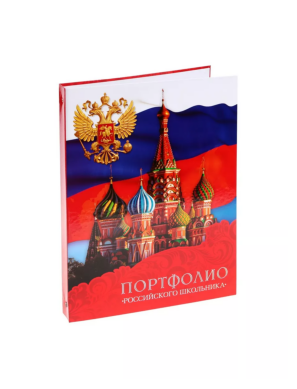

In [47]:
next(preds)

In [31]:
from torchmetrics.text import WordErrorRate
from sacrebleu import corpus_bleu
from torchtext.data.metrics import bleu_score
from torchmetrics import BLEUScore

In [80]:
preds = ['стикеры для заметок прозрачные 100 штук 9 6 см х 8']
target = ['стикеры для заметок прозрачные 100 штук 9 6 см х 7 см имеют матовую поверхность поэтому на них удобно писать стикеры для книг удобны для подчеркивания и выделения нужных фрагментов текста и зарисовок заполните стикеры закладки важными заданиями рисунками или датами они легко наклеиваются и отклеиваются не оставляют следов это идеальный выбор для организации вашего рабочего пространства']

print(corpus_bleu(preds, [target]))

BLEU = 1.36 90.9/90.0/88.9/87.5 (BP = 0.015 ratio = 0.193 hyp_len = 11 ref_len = 57)


In [29]:
preds = ["this is the prediction", "there is an other sample"]
target = ["this is the reference", "there is another one"]
wer = WordErrorRate()
print(wer(preds, target))
print(corpus_bleu(preds, [target]).score)

tensor(0.5000)
29.84745896009822


In [52]:
preds = ["this is the prediction", "there is another one"]
target = ["this is the reference", "there is another one"]
print(corpus_bleu(preds, [target]).score)

72.31269021297696


In [30]:
preds = ["this is the prediction", "there is an other sample"]
target = ["this is the prediction", "there is another one"]
wer = WordErrorRate()
print(wer(preds, target))
print(corpus_bleu(preds, [target]).score)

tensor(0.3750)
47.47362087808389


In [137]:
preds = [['this', 'is', 'the', 'prediction'], ['there', 'is', 'an', 'other', 'sample']]
target = [[['this', 'is', 'the', 'prediction']], [['there', 'is', 'another', 'one']]]

print(bleu_score(preds, target))

0.47473621368408203


In [141]:
preds = ["this is the prediction", "there is an other sample"]
target = [["this is the reference"], ["there is another one"]]


bleu = BLEUScore()
bleu(preds, target)

tensor(0.)

In [114]:
[i.split() for i in preds]

[['this', 'is', 'the', 'prediction'], ['there', 'is', 'an', 'other', 'sample']]

In [111]:
[[i.split()] for i in target]

[[['this', 'is', 'the', 'reference']], [['there', 'is', 'another', 'one']]]

In [120]:
candidate_corpus = [['My', 'full', 'pytorch', 'test'], ['Another', 'Sentence']]
references_corpus = [[['My', 'full', 'pytorch', 'test']], [['Completely', 'Different']]]
bleu_score(candidate_corpus, references_corpus)

0.8408964276313782

In [34]:
def det_test(a):
    return a

check = True
det_test(a=1 if check else 2)

1